# Implementation of SVM from scratch using Quadratic Programming 

#### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt #this is the library used for quadratic solver

In [2]:
import numpy as np
import cvxopt

class svm_scratch:
    def __init__(self, kernel='linear', C=None, d=3, gamma=0.5):
        """
        SVM Classifier (Scratch Implementation)
        
        Parameters:
        - kernel: 'linear', 'polynomial', or 'gaussian'
        - C: Regularization parameter (None for hard margin, float for soft margin)
        - d: Degree of polynomial kernel
        - gamma: Parameter for Gaussian (RBF) kernel
        """
        self.kernel = kernel
        self.C = C
        self.d = d
        self.gamma = gamma
        self.alphas = None
        self.b = None
    
    def compute_gram_matrix(self, X):
        """Computes the Gram (Kernel) matrix."""
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            for j in range(n_samples):
                if self.kernel == 'linear':
                    K[i, j] = np.dot(X[i], X[j])  
                elif self.kernel == 'polynomial':
                    K[i, j] = (np.dot(X[i], X[j]) + 1) ** self.d  
                elif self.kernel == 'gaussian':
                    K[i, j] = np.exp(-self.gamma * np.linalg.norm(X[i] - X[j])**2)  

        return K

    def compute_kernel_value_prediction(self, x1, x2):
        """Computes the kernel value for two input points."""
        if self.kernel == 'linear':
            return np.dot(x1, x2)  
        elif self.kernel == 'polynomial':
            return (np.dot(x1, x2) + 1) ** self.d  
        elif self.kernel == 'gaussian':
            return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)

    def solve_qp(self, K, y):
        """Solves the Quadratic Programming problem for dual SVM."""
        n_samples = y.shape[0]

        # Quadratic term
        P = cvxopt.matrix(np.outer(y, y) * K)
        # Linear term
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        # Equality constraint
        A = cvxopt.matrix(y, (1, n_samples), 'd')
        b = cvxopt.matrix(0.0)

        # Inequality constraints
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))  
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))  
            h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        # Solve QP problem
        cvxopt.solvers.options['show_progress'] = True
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        return np.ravel(solution['x'])

    def compute_b(self, X, y, K, alphas):
        """Computes the bias term `b`."""
        sv = alphas > 1e-5
        ind = np.arange(len(alphas))[sv]
        alphas = alphas[sv]  
        self.sv_X = X[sv]  
        self.sv_y = y[ind]  

        b = 0
        for n in range(len(alphas)):
            b += self.sv_y[n]
            b -= np.sum(alphas * self.sv_y * K[ind[n], sv])
        b = b / len(alphas)

        return b

    def fit(self, X, y):
        """Fits the SVM model using training data."""
        K = self.compute_gram_matrix(X)
        self.alphas = self.solve_qp(K, y)
        self.b = self.compute_b(X, y, K, self.alphas)
        return self.alphas, self.b

    def predict(self, X_test):
        """Predict method (to be implemented later)."""
        y_pred = []
        for x in X_test:
            sum_term = 0
            for i in range(len(self.sv_X)):  # Loop through each support vector
                K_value = self.compute_kernel_value_prediction(self.sv_X[i], x)  # Compute kernel
                sum_term += self.alphas[i] * self.sv_y[i] * K_value  # Multiply & sum
                #print(K_value)
            prediction = np.sign(sum_term + self.b)  # Apply sign function
            y_pred.append(prediction)
        
        return np.array(y_pred)


#### Example 1: Linear dataset

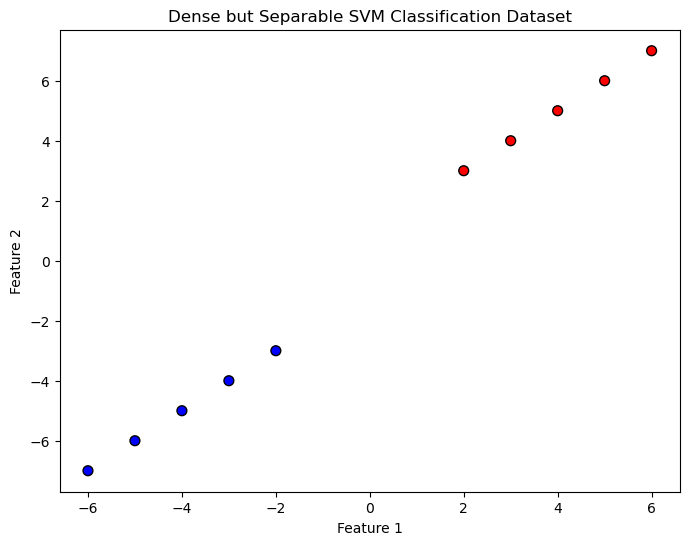

In [4]:
X = np.array([
    [2, 3], [3, 4], [4, 5], [5, 6], [6, 7],  # Class +1
    [-2, -3], [-3, -4], [-4, -5], [-5, -6], [-6, -7]  # Class -1
])

# Labels (5 positive, 5 negative)
y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1])

plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', s=50)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Dense but Separable SVM Classification Dataset")
plt.show()

In [5]:
svm = svm_scratch(kernel="linear", C= 1)
alphas, b = svm.fit(X, y)

     pcost       dcost       gap    pres   dres
 0: -5.8956e-01 -1.3432e+01  6e+01  2e+00  4e-15
 1: -3.6684e-01 -5.4040e+00  8e+00  2e-01  3e-15
 2: -1.6403e-02 -5.8810e-01  8e-01  1e-02  2e-15
 3: -1.8573e-02 -7.4243e-02  6e-02  1e-04  6e-16
 4: -3.3873e-02 -3.9132e-02  5e-03  9e-06  6e-16
 5: -3.8411e-02 -3.8488e-02  8e-05  1e-07  2e-16
 6: -3.8461e-02 -3.8462e-02  8e-07  1e-09  3e-16
 7: -3.8462e-02 -3.8462e-02  8e-09  1e-11  3e-16
Optimal solution found.


In [6]:
def plot_decision_boundary(X, y, alphas, b, kernel='linear'):
    plt.figure(figsize=(8, 6))
    
    # Plot all data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', s=50, label="Data points")

    # Get support vectors
    support_vectors = X[alphas > 1e-5]
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, edgecolors='k', facecolors='none', label="Support Vectors")

    # Generate grid points
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Compute decision function for each grid point
    if kernel == 'linear':
        w = np.sum(alphas[:, None] * y[:, None] * X, axis=0)
        zz = np.dot(np.c_[xx.ravel(), yy.ravel()], w) + b
        zz = zz.reshape(xx.shape)
    else:
        raise ValueError("Only linear kernel visualization supported!")

    # Plot decision boundary
    plt.contour(xx, yy, zz, levels=[0], colors='k', linewidths=2, label="Decision Boundary")
    
    # Plot margins
    plt.contour(xx, yy, zz, levels=[-1, 1], colors='gray', linestyles='dashed', linewidths=1)

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("SVM Decision Boundary")
    plt.legend()
    plt.show()

C:\Users\Anas\AppData\Local\Temp\ipykernel_11132\3401908056.py:26: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, zz, levels=[0], colors='k', linewidths=2, label="Decision Boundary")


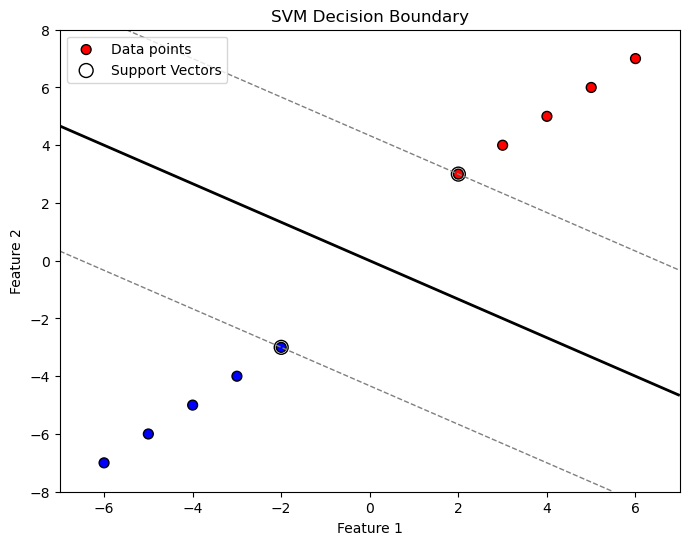

In [7]:
plot_decision_boundary(X, y, alphas, b )

#### Example2: Non-Linear dataset (GAussian)

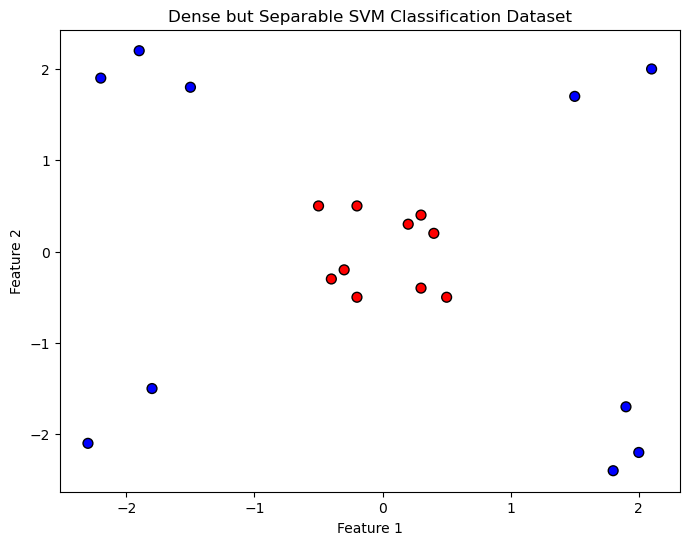

In [9]:
X_pos = np.array([
    [0.2, 0.3], [0.4, 0.2], [-0.3, -0.2], [-0.2, 0.5], [0.3, -0.4],
    [0.5, -0.5], [-0.5, 0.5], [-0.4, -0.3], [0.3, 0.4], [-0.2, -0.5]
])

# 10 points for class -1 (outer points outside the circular region)
X_neg = np.array([
    [1.5, 1.7], [-1.8, -1.5], [2.0, -2.2], [-2.2, 1.9], [1.9, -1.7],
    [-1.5, 1.8], [2.1, 2.0], [-2.3, -2.1], [1.8, -2.4], [-1.9, 2.2]
])

# Combine both classes
X = np.vstack((X_pos, X_neg))

# Labels (+1 for inner points, -1 for outer points)
y = np.array([1] * 10 + [-1] * 10)

plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', s=50)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Dense but Separable SVM Classification Dataset")
plt.show()

In [10]:
svm = svm_scratch(kernel="gaussian", C= 0.1)
alphas, b = svm.fit(X, y)

     pcost       dcost       gap    pres   dres
 0: -2.1079e+00 -3.8741e+00  6e+01  7e+00  2e-16
 1: -1.6719e+00 -3.3122e+00  3e+00  2e-01  3e-16
 2: -1.4836e+00 -1.7399e+00  3e-01  1e-16  7e-16
 3: -1.5349e+00 -1.5401e+00  5e-03  7e-17  4e-16
 4: -1.5377e+00 -1.5377e+00  5e-05  7e-17  4e-16
 5: -1.5377e+00 -1.5377e+00  5e-07  9e-17  3e-16
Optimal solution found.


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary_color(X, y, model, resolution=100):
    """
    Decision boundary plot karta hai colored regions ke sath.
    
    Parameters:
        X (numpy.ndarray): Training dataset
        y (numpy.ndarray): Labels (-1 or +1)
        model (svm_scratch object): Trained SVM model
        resolution (int): Grid resolution for visualization
    """
    # Grid create karo min-max range ke andar
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    # Har point pe prediction le lo
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)  # SVM prediction
    Z = Z.reshape(xx.shape)

    # Plot karo decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Non-Linear SVM Decision Boundary ')
    plt.show()


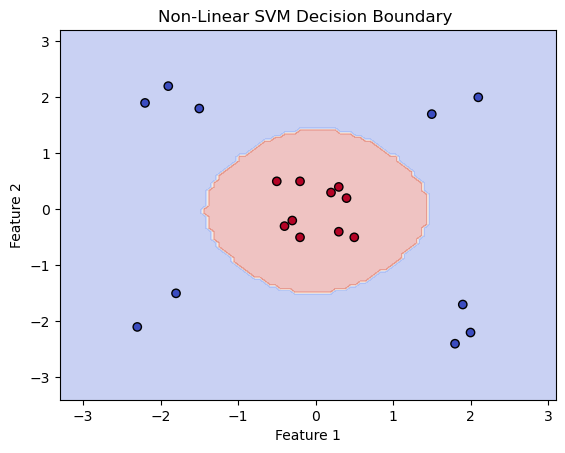

In [14]:
plot_decision_boundary_color(X, y, svm)


#### Example 3: Polynomial

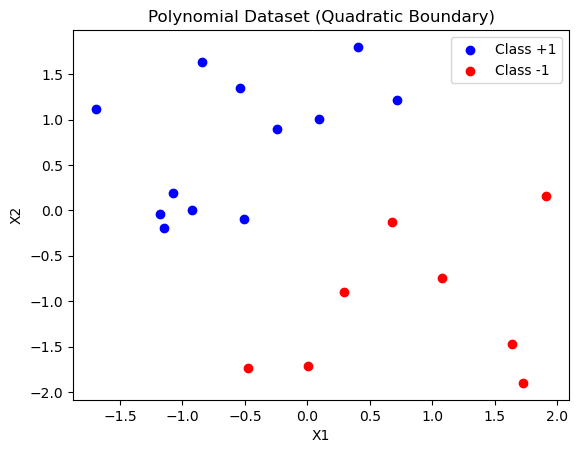

In [15]:
np.random.seed(7)

# Generate random X values
X = np.random.uniform(-2, 2, (20, 2))

# Class labels using a cubic decision boundary: x2 > x1^3
y = np.where(X[:, 1] > (X[:, 0]**3), 1, -1)

# Scatter plot
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='b', label="Class +1")
plt.scatter(X[y == -1, 0], X[y == -1, 1], color='r', label="Class -1")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Polynomial Dataset (Quadratic Boundary)")
plt.legend()
plt.show()

In [16]:
svm = svm_scratch(kernel="polynomial", C=0.09, d=2)
alphas, b = svm.fit(X, y)

     pcost       dcost       gap    pres   dres
 0: -2.1652e+00 -2.8398e+00  8e+01  9e+00  1e-15
 1: -4.4748e-01 -2.6443e+00  4e+00  3e-01  1e-15
 2: -3.4730e-01 -9.1472e-01  6e-01  8e-17  5e-16
 3: -4.0799e-01 -4.9945e-01  9e-02  6e-17  3e-16
 4: -4.3875e-01 -4.5655e-01  2e-02  6e-17  3e-16
 5: -4.4495e-01 -4.4664e-01  2e-03  8e-17  3e-16
 6: -4.4562e-01 -4.4570e-01  8e-05  7e-17  2e-16
 7: -4.4565e-01 -4.4566e-01  3e-06  7e-17  3e-16
 8: -4.4565e-01 -4.4565e-01  4e-08  8e-17  2e-16
Optimal solution found.


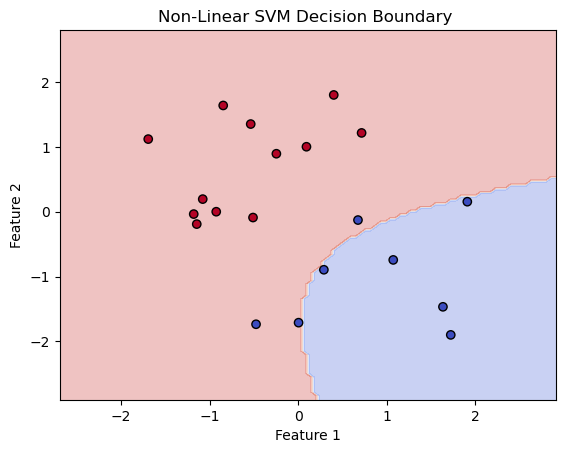

In [17]:
plot_decision_boundary_color(X, y, svm)